In [1]:
%load_ext autoreload
%autoreload 2

from itertools import product

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from simulator import FraudForcastingDataSimulator
from models import LossDevelopmentCurveModel
import weibull as wb

In [2]:
MATURATION_TIME = 31*3

In [3]:
simulator = FraudForcastingDataSimulator(ultimate_loss_mean=100.0, ultimate_loss_std=10.0)
g = simulator.simulate_one_random_group()

Text(0, 0.5, 'Loss')

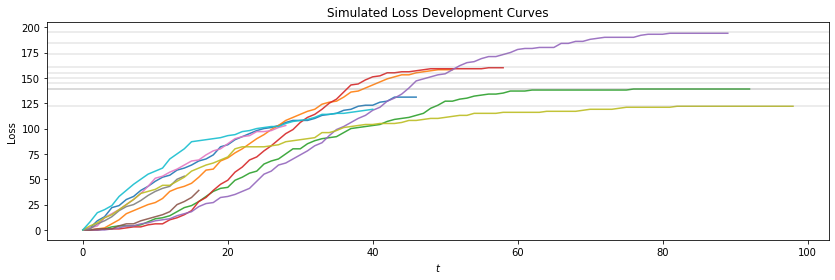

In [380]:
fig, ax = plt.subplots(figsize=(14, 4))

simulator = FraudForcastingDataSimulator(ultimate_loss_mean=150.0, ultimate_loss_std=30.0)

for _ in range(10):
    group = simulator.simulate_one_random_group()
    ax.plot(group['t'], group['y'], alpha=0.9)
    ax.axhline(group['ultimate_loss'][0], color='grey', alpha=0.2)

ax.set_title("Simulated Loss Development Curves")
ax.set_xlabel("$t$")
ax.set_ylabel("Loss")

Text(0.5, 1.0, 'Model Likelihood and Loss')

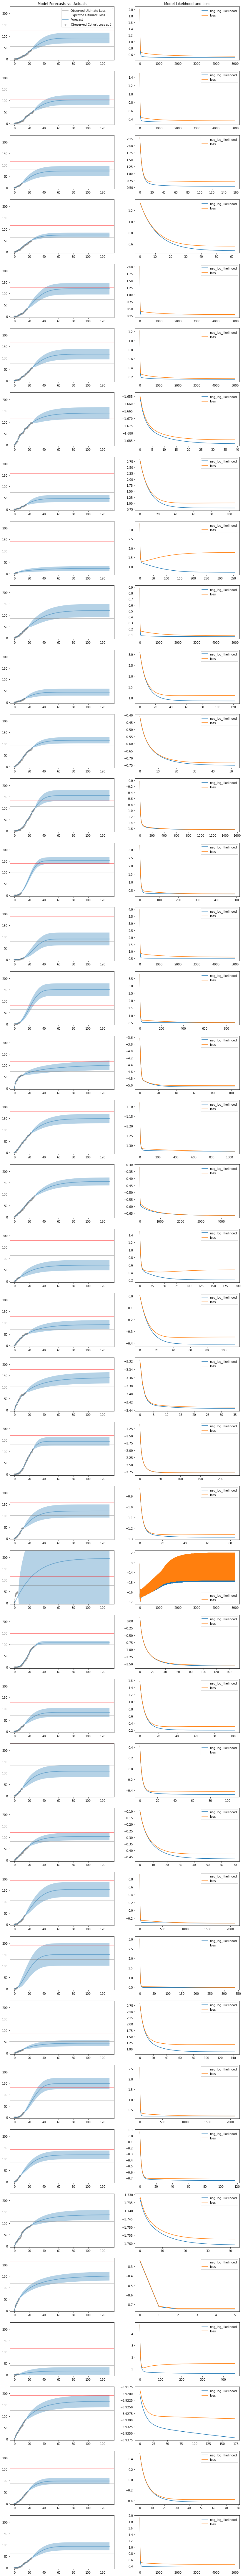

In [468]:
N = 40

simulator = FraudForcastingDataSimulator(
    n_obs_min=5, n_obs_max=30, ultimate_loss_mean=150.0, ultimate_loss_std=30.0)
models = []

fig, axs = plt.subplots(N, 2, figsize=(14, 4*N))

for ax0, ax1 in axs:
    
    df = simulator.simulate_multiple_groups(n_groups=1)
    
    ax0.plot(df['t'], df['y'], color='grey', linestyle='--', linewidth=2)
    ax0.scatter(df['t'], df['y'], color='grey', s=25, alpha=0.5, label="Obeserved Cohort Loss at $t$")

    ax0.axhline(df['ultimate_loss'][0], color='grey', alpha=0.6, label="Observed Ultimate Loss")
    ax0.axhline(df['expected_ultimate_loss'][0], color='red', alpha=0.6, label="Expected Ultimate Loss")
    
    model = LossDevelopmentCurveModel(
        ul_prior_mean=150.0, ul_prior_std=30.0, initial_ul=150.0,
        shrinkage=0.01)
    model.fit(df['t'].values, df['y'].values)
    
    t = np.arange(130)
    forecast = model.forecast(t)
    ax0.plot(t, forecast, alpha=0.5, linewidth=2, label="Forecast")
    
    max_t = np.max(df['t'])
    t = np.arange(max_t + 1, 130)
    ax0.fill_between(
        t, 
        forecast[max_t + 1:] + 3 * model.forecast_interval(t), 
        forecast[max_t + 1:] - 3 * model.forecast_interval(t),
        alpha=0.33
    )
    
    ax0.set_ylim([-5.0, 230.0])
    
    ax1.plot(np.arange(len(model.log_likelihoods)), -np.array(model.log_likelihoods), label='neg_log_likelihood')
    ax1.plot(np.arange(len(model.losses)), model.losses, label='loss')     
    ax1.legend()
    
axs[0][0].legend()
axs[0][0].set_title("Model Forecasts vs. Actuals")
axs[0][1].legend()
axs[0][1].set_title("Model Likelihood and Loss")